In [1]:
%load_ext autoreload
%autoreload 2 


In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import h5py
import torchvision
import numpy as np
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from aux_functions import put_gaze_annotation, rgb,angle_to_2d,is_accurate, plot_metrics
from datasets import MPIIFaceGaze
from random import randint

# Tarea a resolver:

- Se desea predecir el ángulo de la mirada de un individuo a partir de una foto de su cara.
- Para eso se utilizará el dataset de MPIIFaceGaze. [Link aqui](https://www.mpi-inf.mpg.de/de/departments/computer-vision-and-machine-learning/research/gaze-based-human-computer-interaction/its-written-all-over-your-face-full-face-appearance-based-gaze-estimation).
    - El dataset consiste en imágenes de caras de 15 individuos distintos, mirando a diferentes lugares.
    - Se tienen 3000 imágenes por individuo con sus labels de pitch (ángulo vertical) y yaw (ángulo horizontal).
    - Las imágenes se tomaron de usuarios utilizando sus laptops durante 3 meses. 

# 0. Configuraciones

Configuraciones para CUDA

In [3]:
# Configuraciones para CUDA
os.environ["CUDA_LAUNCH_BLOCKING"]="1"

In [4]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device a utilizar:",device)

Device a utilizar: cuda


# 1. Análisis de datos

En esta sección se analizan los siguientes aspectos del dataset:
1. Cantidad de imágenes y participantes
1.  Distribución de los ángulos de mirada en el dataset.

- El dataset se encuentra en un archivo con formato h5 localizado en la carpeta "datasets"

## 1.1. Cantidad de imágenes

In [5]:
with h5py.File('./datasets/MPIIFaceGaze.h5', 'r') as file:

    cant_imagenes = 0
    cant_imagenes_persona = []
    gaze_data = []

    for person_idx in range(len(file)):

        person = f"p{person_idx:02d}"
        dataset = file[person]

        images = dataset["image"]
        gaze = dataset["gaze"]
        pose = dataset["pose"]

        cant_imagenes += len(images)
        cant_imagenes_persona.append(len(images))

        # Almaceno todos los labels de miradas [pitch,yaw] del participante
        for i,g in enumerate(gaze):
            i_key = f"{i:04d}"
            gaze_data.append(np.array(gaze[i_key],dtype=float))

print(f"En el dataset hay: {cant_imagenes} imágenes de {len(cant_imagenes_persona)} personas.")
print(f"Las imágenes por persona son: {cant_imagenes_persona}")

/tmp/ipykernel_3321552/2887136188.py:22: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  gaze_data.append(np.array(gaze[i_key],dtype=float))


En el dataset hay: 45000 imágenes de 15 personas.
Las imágenes por persona son: [3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000]


Vemos que hay 3000 imágenes por cada persona y se tienen 15 sujetos diferentes. Veamos ahora la distribución de los ángulos de la mirada:

## 1.2. Distribución de ángulos de las miradas

En el dataset los ángulos de la mirada están representados por dos valores, pitch y yaw. Estos representan la rotación horizontal y vertical

En la siguiente imágen se ilustran los ángulos:

![head_ref.png](head_ref.png)

Se analizará la distribución entonces de:

- Pitch: Componente asociada al movimiento vertical.
- Yaw: Componente asociada al movimiento horizontal.
- Angle_2d: Proyección del ángulo en 2 dimensiones (para más información ver el archivo aux_functions.py)

In [6]:
gaze_array = np.array(gaze_data)
pitch_array = gaze_array[:,0]
yaw_array = gaze_array[:,1]
projected_2d_angle_array = angle_to_2d(gaze_array)

### 1.2.1 Pitch

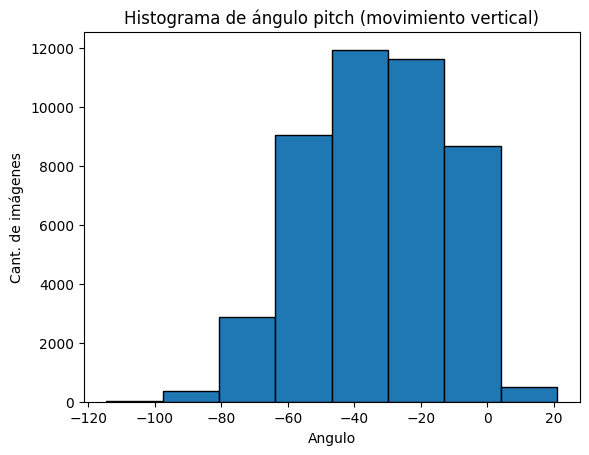

In [7]:
pitch_array_deg = np.rad2deg(pitch_array*np.pi)
plt.hist(pitch_array_deg, bins=8, edgecolor='black')
plt.xlabel('Angulo')
plt.ylabel('Cant. de imágenes')
plt.title('Histograma de ángulo pitch (movimiento vertical)')
plt.show()

### 1.2.2 Yaw

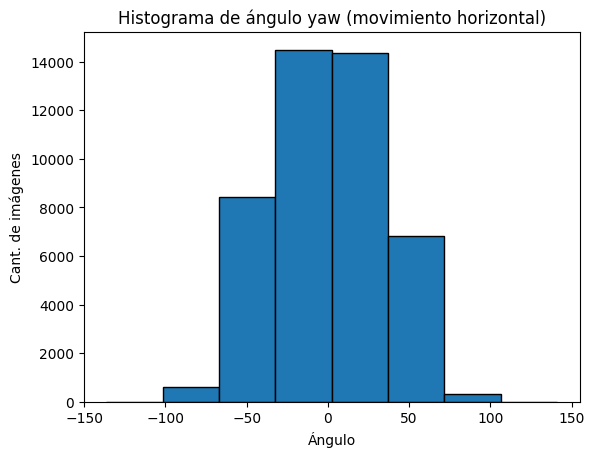

In [8]:
yaw_array_deg = np.rad2deg(yaw_array*np.pi)
plt.hist(yaw_array_deg, bins=8, edgecolor='black')
plt.xlabel('Ángulo')
plt.ylabel('Cant. de imágenes')
plt.title('Histograma de ángulo yaw (movimiento horizontal)')
plt.show()

### 1.2.3 Proyección de ángulos 2D

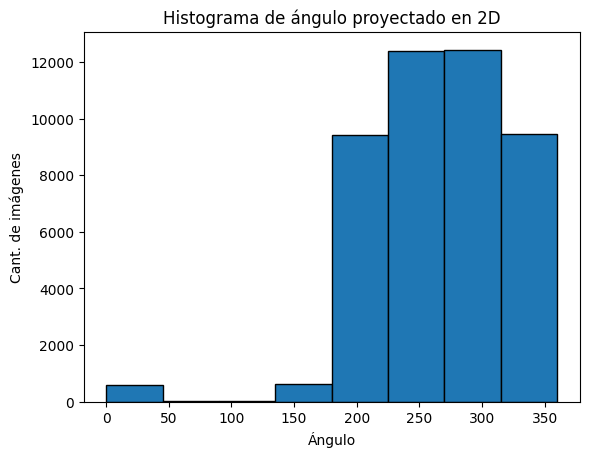

In [9]:
plt.hist(projected_2d_angle_array, bins=8, edgecolor='black')
plt.xlabel('Ángulo')
plt.ylabel('Cant. de imágenes')
plt.title('Histograma de ángulo proyectado en 2D')
plt.show()

### 1.2.4 Polar plot de pitch y yaw

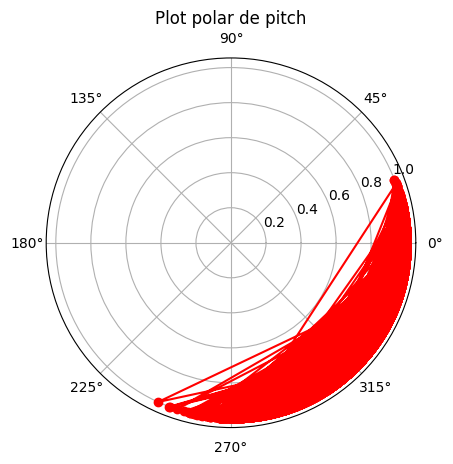

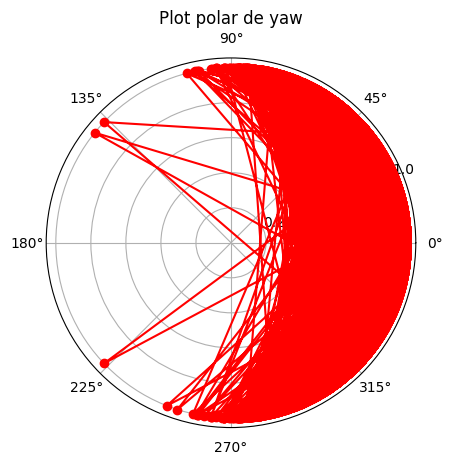

In [10]:
magnitude_array = np.ones_like(pitch_array)

# Pitch
plt.polar(pitch_array*np.pi, magnitude_array, marker='o', linestyle='-', color='r')
plt.title('Plot polar de pitch')
# Show the plot
plt.show()

# Yaw
plt.polar(yaw_array*np.pi, magnitude_array, marker='o', linestyle='-', color='r')
plt.title('Plot polar de yaw')
# Show the plot
plt.show()

### 1.2.5 Distribución conjunta de pitch y yaw



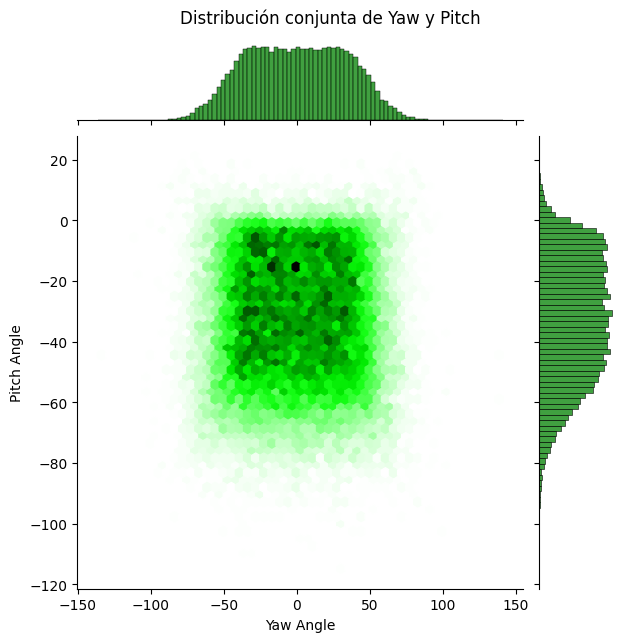

In [11]:
import seaborn as sns

sns.jointplot(x=yaw_array_deg, y=pitch_array_deg, kind="hex", color="g")
plt.xlabel('Yaw Angle')
plt.ylabel('Pitch Angle')
plt.suptitle('Distribución conjunta de Yaw y Pitch', y=1.03)
plt.show()

## 2. Preparación del dataset

- Para facilitar la carga de datos a pytorch se crea una clase que se hereda de torch.utils.Dataset. El código asociado se encuentra en el archivo _datasets.py_

In [12]:
from datasets import MPIIFaceGaze

In [13]:
# Selecciono pocas imágenes, solo para probar la que la clase funcione bien 
ds = MPIIFaceGaze("./datasets/MPIIFaceGaze.h5", imgs_per_individual=3)
print(f"Se cargaron {len(ds)} imagenes")

Dataset cargado correctamente de /home/idk/git/ceia/vpc2_project/datasets/MPIIFaceGaze.h5
Se cargaron 45 imagenes


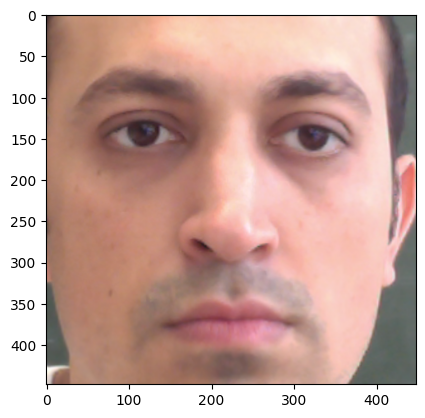

In [14]:
plt.imshow(ds.images_list[20][:,:,::-1])

## 2.1 Data augmentation

In [26]:
WIDTH = 224 
HEIGHT = 224

# Transformación de tamaño y data augmentation
data_transforms = transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((WIDTH, HEIGHT)),
    # torchvision.transforms.RandomHorizontalFlip(0.5), # No se puede usar aqui porque altera la dirección de la mirada
    # torchvision.transforms.RandomVerticalFlip(0.5), # No se puede usar aqui porque altera la dirección de la mirada
    torchvision.transforms.RandomResizedCrop(size=(WIDTH, HEIGHT), scale=(0.9, 1.0)),
    torchvision.transforms.ColorJitter(saturation=0.1, hue=0.1),
])


In [27]:
# Ahora sí cargamos todas las imágenes que se van a utilizar en el entrenamiento
ds = MPIIFaceGaze("./datasets/MPIIFaceGaze.h5", transform=data_transforms, imgs_per_individual=350)
print(f"Se cargaron {len(ds)} imagenes")

Dataset cargado correctamente de /home/idk/git/ceia/vpc2_project/datasets/MPIIFaceGaze.h5
Se cargaron 5250 imagenes


Ahora se separará el set en entrenamiento y testeo y luego se visualizarán las transformaciones

## 2.2 Creación de los set de entrenamiento y testeo

- Al usar resnet18 como capas previas (para aprovechar y hacer transfer learning), las imagenes deben ser redimensionadas a 224x224
- Data augmentation:
    - RandomResizedCrop: Se busca cortar y redimensionar la imagen aleatoreamente para generar más diversidad de datos
    - ColorJitter: Se realizan leves cambios en la saturación y el tono para garantizar más robustez ante distintas varaciones lumínicas y de color de ojos
    - No se pueden realizar transformaciones como HorizontalFlip o VerticalFlip porque alteran la posición de la mirada.

In [29]:
# Separo en entrenamiento y validacion (70% train, 30% test)
train_size = int(0.7*len(ds))  
test_size = len(ds)-train_size

train_dataset, test_dataset = random_split(ds, [train_size, test_size])

# Creo los dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)


torch.Size([64, 3, 224, 224]) torch.Size([64, 2])
pitch yaw: tensor([-0.0935,  0.0857], dtype=torch.float64)


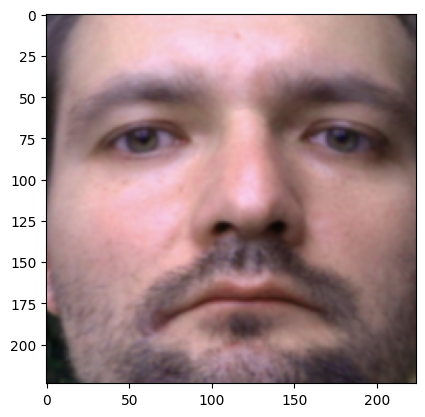

In [30]:
# Obtengo una imagen para visualizar las transformaciones
train_image, train_labels = next(iter(train_loader))

print(train_image.shape, train_labels.shape)

# Graficamos la imagen junto con el label para asegurarnos que esté bien cargada 
plt.imshow(train_image[0].permute(1, 2, 0).numpy()[:,:,::-1])
print(f'pitch yaw: {train_labels[0]}')

# 3. Modelos

Se probarán los siguientes modelos:

- Modelo _custom_: red neuronal hecha desde cero, con capas convolucionales y fully connected.

- Modelo basado en ResNet18:
    - Transfer Learning a partir de una ResNet 18.
    - Se congelan las primeras capas (para que no sean entrenables).
    - Se agregan 2 capas fully connected al final.

- Modelo basado en ResNet34:
    - Transfer Learning a partir de una ResNet 34.
    - Se congelan las primeras capas (para que no sean entrenables).
    - Se agregan 2 capas fully connected al final.

In [31]:
from models import GazeEstimation_ResNet18, GazeEstimation_ResNet34, CNN_custom
from torchsummary import summary


## 3.1 Red CNN propia

### 3.1.1 Instanciación

In [36]:
# Instanciación del modelo con una red CNN propia
model_cnn_propia = CNN_custom(name="cnn_propia")
model_cnn_propia.dynamic_lr = True
model_cnn_propia.lr_adjustment_ratio = 0.1
model_cnn_propia.minimum_lr = 1e-4
model_cnn_propia.lr_epochs_adjustment = 20 # Cada 20 epochs se reduce el learning rate por un factor de 0.2

# Al ser un problema de regresión se usa MSELoss
criterion = nn.MSELoss()

# Optimizador: Adam
optimizer = torch.optim.Adam(model_cnn_propia.parameters(), lr=1e-3)

#Summary
summary(model_cnn_propia.to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]           1,216
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,640
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
         Dropout2d-9           [-1, 32, 56, 56]               0
           Conv2d-10           [-1, 64, 56, 56]          18,496
      BatchNorm2d-11           [-1, 64, 56, 56]             128
             ReLU-12           [-1, 64, 56, 56]               0
        MaxPool2d-13           [-1, 64, 28, 28]               0
        Dropout2d-14           [-1, 64,

### 3.1.2. Entrenamiento

In [37]:
model_cnn_propia.fit(train_loader, val_loader, criterion, optimizer, epochs=50, device=device, save_model=True)

Epoch 1/50


Validation loss 0.92955: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s]


[Lr:0.001] Training Loss / Accuracy: 58.8494 / 7.84% | Validation Loss / Accuracy: 0.9296 / 8.21%
Epoch 2/50


Validation loss 0.03915: 100%|██████████| 25/25 [00:19<00:00,  1.29it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/cnn_propia.pth
[Lr:0.001] Training Loss / Accuracy: 0.1669 / 11.87% | Validation Loss / Accuracy: 0.0392 / 15.99%
Epoch 3/50


Validation loss 0.03320: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/cnn_propia.pth
[Lr:0.001] Training Loss / Accuracy: 0.0523 / 14.22% | Validation Loss / Accuracy: 0.0332 / 16.40%
Epoch 4/50


Validation loss 0.02970: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/cnn_propia.pth
[Lr:0.001] Training Loss / Accuracy: 0.0434 / 15.82% | Validation Loss / Accuracy: 0.0297 / 16.41%
Epoch 5/50


Validation loss 0.02894: 100%|██████████| 25/25 [00:19<00:00,  1.28it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/cnn_propia.pth
[Lr:0.001] Training Loss / Accuracy: 0.0397 / 17.06% | Validation Loss / Accuracy: 0.0289 / 16.17%
Epoch 6/50


Validation loss 0.02929: 100%|██████████| 25/25 [00:19<00:00,  1.26it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0362 / 16.55% | Validation Loss / Accuracy: 0.0293 / 17.86%
Epoch 7/50


Validation loss 0.02686: 100%|██████████| 25/25 [00:19<00:00,  1.29it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/cnn_propia.pth
[Lr:0.001] Training Loss / Accuracy: 0.0345 / 17.47% | Validation Loss / Accuracy: 0.0269 / 16.14%
Epoch 8/50


Validation loss 0.02590: 100%|██████████| 25/25 [00:19<00:00,  1.28it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/cnn_propia.pth
[Lr:0.001] Training Loss / Accuracy: 0.0325 / 18.12% | Validation Loss / Accuracy: 0.0259 / 16.80%
Epoch 9/50


Validation loss 0.02582: 100%|██████████| 25/25 [00:19<00:00,  1.31it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/cnn_propia.pth
[Lr:0.001] Training Loss / Accuracy: 0.0330 / 17.92% | Validation Loss / Accuracy: 0.0258 / 18.19%
Epoch 10/50


Validation loss 0.02657: 100%|██████████| 25/25 [00:19<00:00,  1.29it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0310 / 19.07% | Validation Loss / Accuracy: 0.0266 / 19.35%
Epoch 11/50


Validation loss 0.02429: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/cnn_propia.pth
[Lr:0.001] Training Loss / Accuracy: 0.0311 / 19.03% | Validation Loss / Accuracy: 0.0243 / 18.11%
Epoch 12/50


Validation loss 0.02488: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0307 / 18.07% | Validation Loss / Accuracy: 0.0249 / 18.14%
Epoch 13/50


Validation loss 0.02595: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0289 / 20.08% | Validation Loss / Accuracy: 0.0259 / 20.51%
Epoch 14/50


Validation loss 0.02315: 100%|██████████| 25/25 [00:19<00:00,  1.29it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/cnn_propia.pth
[Lr:0.001] Training Loss / Accuracy: 0.0284 / 20.99% | Validation Loss / Accuracy: 0.0231 / 19.34%
Epoch 15/50


Validation loss 0.02354: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s]


[Lr:0.0003] Training Loss / Accuracy: 0.0266 / 20.94% | Validation Loss / Accuracy: 0.0235 / 19.26%
Epoch 16/50


Validation loss 0.02311: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/cnn_propia.pth
[Lr:0.0003] Training Loss / Accuracy: 0.0266 / 19.94% | Validation Loss / Accuracy: 0.0231 / 19.90%
Epoch 17/50


Validation loss 0.02328: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s]


[Lr:0.0003] Training Loss / Accuracy: 0.0265 / 20.83% | Validation Loss / Accuracy: 0.0233 / 19.69%
Epoch 18/50


Validation loss 0.02360: 100%|██████████| 25/25 [00:19<00:00,  1.28it/s]


[Lr:0.0003] Training Loss / Accuracy: 0.0269 / 20.87% | Validation Loss / Accuracy: 0.0236 / 18.71%
Epoch 19/50


Validation loss 0.02325: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s]


[Lr:0.0003] Training Loss / Accuracy: 0.0267 / 20.82% | Validation Loss / Accuracy: 0.0233 / 19.79%
Epoch 20/50


Validation loss 0.02329: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s]


[Lr:0.0003] Training Loss / Accuracy: 0.0263 / 20.63% | Validation Loss / Accuracy: 0.0233 / 21.25%
Epoch 21/50


Validation loss 0.02268: 100%|██████████| 25/25 [00:19<00:00,  1.29it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/cnn_propia.pth
[Lr:0.0003] Training Loss / Accuracy: 0.0260 / 21.17% | Validation Loss / Accuracy: 0.0227 / 18.92%
Epoch 22/50


Validation loss 0.02296: 100%|██████████| 25/25 [00:19<00:00,  1.31it/s]


[Lr:0.0003] Training Loss / Accuracy: 0.0251 / 21.79% | Validation Loss / Accuracy: 0.0230 / 20.74%
Epoch 23/50


Validation loss 0.02265: 100%|██████████| 25/25 [00:19<00:00,  1.31it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/cnn_propia.pth
[Lr:0.0003] Training Loss / Accuracy: 0.0254 / 21.69% | Validation Loss / Accuracy: 0.0227 / 20.39%
Epoch 24/50


Validation loss 0.02309: 100%|██████████| 25/25 [00:19<00:00,  1.31it/s]


[Lr:0.0003] Training Loss / Accuracy: 0.0252 / 21.21% | Validation Loss / Accuracy: 0.0231 / 19.95%
Epoch 25/50


Validation loss 0.02291: 100%|██████████| 25/25 [00:19<00:00,  1.28it/s]


[Lr:0.0003] Training Loss / Accuracy: 0.0253 / 21.15% | Validation Loss / Accuracy: 0.0229 / 20.20%
Epoch 26/50


Validation loss 0.02230: 100%|██████████| 25/25 [00:19<00:00,  1.28it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/cnn_propia.pth
[Lr:0.0003] Training Loss / Accuracy: 0.0254 / 21.34% | Validation Loss / Accuracy: 0.0223 / 20.66%
Epoch 27/50


Validation loss 0.02264: 100%|██████████| 25/25 [00:19<00:00,  1.29it/s]


[Lr:0.0003] Training Loss / Accuracy: 0.0256 / 21.28% | Validation Loss / Accuracy: 0.0226 / 19.80%
Epoch 28/50


Validation loss 0.02253: 100%|██████████| 25/25 [00:19<00:00,  1.31it/s]


[Lr:0.0003] Training Loss / Accuracy: 0.0252 / 22.13% | Validation Loss / Accuracy: 0.0225 / 21.01%
Epoch 29/50


Validation loss 0.02316: 100%|██████████| 25/25 [00:19<00:00,  1.29it/s]


[Lr:0.0003] Training Loss / Accuracy: 0.0250 / 22.70% | Validation Loss / Accuracy: 0.0232 / 21.09%
Epoch 30/50


Validation loss 0.02270: 100%|██████████| 25/25 [00:18<00:00,  1.32it/s]


[Lr:8.999999999999999e-05] Training Loss / Accuracy: 0.0248 / 21.76% | Validation Loss / Accuracy: 0.0227 / 20.59%
Epoch 31/50


Validation loss 0.02214: 100%|██████████| 25/25 [00:19<00:00,  1.32it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/cnn_propia.pth
[Lr:8.999999999999999e-05] Training Loss / Accuracy: 0.0241 / 22.00% | Validation Loss / Accuracy: 0.0221 / 21.36%
Epoch 32/50


Validation loss 0.02158: 100%|██████████| 25/25 [00:19<00:00,  1.29it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/cnn_propia.pth
[Lr:8.999999999999999e-05] Training Loss / Accuracy: 0.0244 / 22.21% | Validation Loss / Accuracy: 0.0216 / 21.58%
Epoch 33/50


Validation loss 0.02241: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s]


[Lr:8.999999999999999e-05] Training Loss / Accuracy: 0.0244 / 21.80% | Validation Loss / Accuracy: 0.0224 / 21.14%
Epoch 34/50


Validation loss 0.02218: 100%|██████████| 25/25 [00:19<00:00,  1.29it/s]


[Lr:8.999999999999999e-05] Training Loss / Accuracy: 0.0240 / 22.96% | Validation Loss / Accuracy: 0.0222 / 21.33%
Epoch 35/50


Validation loss 0.02181: 100%|██████████| 25/25 [00:19<00:00,  1.27it/s]


[Lr:8.999999999999999e-05] Training Loss / Accuracy: 0.0244 / 21.53% | Validation Loss / Accuracy: 0.0218 / 21.50%
Epoch 36/50


Validation loss 0.02163: 100%|██████████| 25/25 [00:20<00:00,  1.23it/s]


[Lr:8.999999999999999e-05] Training Loss / Accuracy: 0.0244 / 21.95% | Validation Loss / Accuracy: 0.0216 / 21.08%
Epoch 37/50


Validation loss 0.02219: 100%|██████████| 25/25 [00:19<00:00,  1.31it/s]


[Lr:8.999999999999999e-05] Training Loss / Accuracy: 0.0239 / 22.11% | Validation Loss / Accuracy: 0.0222 / 21.85%
Epoch 38/50


Validation loss 0.02147: 100%|██████████| 25/25 [00:19<00:00,  1.28it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/cnn_propia.pth
[Lr:8.999999999999999e-05] Training Loss / Accuracy: 0.0242 / 22.56% | Validation Loss / Accuracy: 0.0215 / 20.94%
Epoch 39/50


Validation loss 0.02237: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s]


[Lr:8.999999999999999e-05] Training Loss / Accuracy: 0.0241 / 22.99% | Validation Loss / Accuracy: 0.0224 / 21.91%
Epoch 40/50


Validation loss 0.02147: 100%|██████████| 25/25 [00:19<00:00,  1.26it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/cnn_propia.pth
[Lr:8.999999999999999e-05] Training Loss / Accuracy: 0.0244 / 22.14% | Validation Loss / Accuracy: 0.0215 / 21.58%
Epoch 41/50


Validation loss 0.02162: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s]


[Lr:8.999999999999999e-05] Training Loss / Accuracy: 0.0240 / 22.03% | Validation Loss / Accuracy: 0.0216 / 20.36%
Epoch 42/50


Validation loss 0.02157: 100%|██████████| 25/25 [00:19<00:00,  1.31it/s]


[Lr:8.999999999999999e-05] Training Loss / Accuracy: 0.0240 / 22.41% | Validation Loss / Accuracy: 0.0216 / 20.94%
Epoch 43/50


Validation loss 0.02135: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/cnn_propia.pth
[Lr:8.999999999999999e-05] Training Loss / Accuracy: 0.0240 / 22.19% | Validation Loss / Accuracy: 0.0213 / 22.95%
Epoch 44/50


Validation loss 0.02168: 100%|██████████| 25/25 [00:19<00:00,  1.29it/s]


[Lr:8.999999999999999e-05] Training Loss / Accuracy: 0.0242 / 22.73% | Validation Loss / Accuracy: 0.0217 / 20.69%
Epoch 45/50


Validation loss 0.02152: 100%|██████████| 25/25 [00:19<00:00,  1.29it/s]


[Lr:2.6999999999999996e-05] Training Loss / Accuracy: 0.0239 / 22.06% | Validation Loss / Accuracy: 0.0215 / 21.52%
Epoch 46/50


Validation loss 0.02156: 100%|██████████| 25/25 [00:19<00:00,  1.31it/s]


[Lr:2.6999999999999996e-05] Training Loss / Accuracy: 0.0239 / 22.46% | Validation Loss / Accuracy: 0.0216 / 21.31%
Epoch 47/50


Validation loss 0.02143: 100%|██████████| 25/25 [00:19<00:00,  1.31it/s]


[Lr:2.6999999999999996e-05] Training Loss / Accuracy: 0.0236 / 21.72% | Validation Loss / Accuracy: 0.0214 / 20.17%
Epoch 48/50


Validation loss 0.02189: 100%|██████████| 25/25 [00:19<00:00,  1.29it/s]


[Lr:2.6999999999999996e-05] Training Loss / Accuracy: 0.0237 / 21.40% | Validation Loss / Accuracy: 0.0219 / 20.66%
Epoch 49/50


Validation loss 0.02141: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s]


[Lr:2.6999999999999996e-05] Training Loss / Accuracy: 0.0237 / 22.49% | Validation Loss / Accuracy: 0.0214 / 21.24%
Epoch 50/50


Validation loss 0.02134: 100%|██████████| 25/25 [00:19<00:00,  1.31it/s]

Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/cnn_propia.pth
[Lr:2.6999999999999996e-05] Training Loss / Accuracy: 0.0235 / 21.87% | Validation Loss / Accuracy: 0.0213 / 21.94%


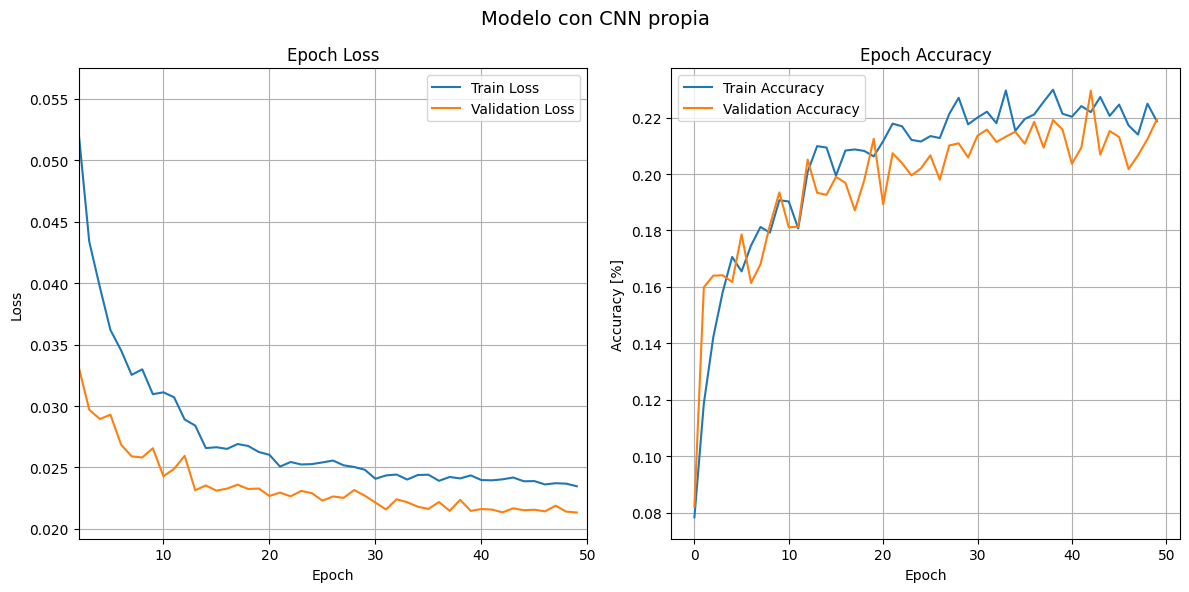

In [38]:
plot_metrics(model_cnn_propia,title="Modelo con CNN propia")

In [23]:
# Para probar que se haya guardado bien el mejor modelo entrenado
new_model = CNN_custom()
new_model.load_state_dict(torch.load('./modelos/cnn_propia.pth'))
new_model.to(device)

inputs = torch.randn(8, 3, 224, 224).to(device)
outputs = new_model(inputs)

print(outputs)

tensor([[-0.2147,  0.0448],
        [-0.3868,  0.0592],
        [-0.2478, -0.2000],
        [-0.2999, -0.1305],
        [-0.0404, -0.0706],
        [-0.2432,  0.0435],
        [-0.0431,  0.0718],
        [-0.2823, -0.0123]], device='cuda:0', grad_fn=<AddmmBackward0>)


/tmp/ipykernel_2302380/2492880537.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_model.load_state_dict(torch.load('./modelos/cnn_propia.pth'))


## 3.2 Red basada en ResNet18

### 3.2.1. Instanciación

In [24]:
# Instanciación del modelo con resnet18
model_resnet18 = GazeEstimation_ResNet18(name="resnet18",pretrained=True) #Debug en True para ver qué capas son entrenables y cuáles no
model_resnet18.dynamic_lr = False
model_resnet18.lr_epochs_adjustment = 30 # Cada 30 epochs se reduce el learning rate por un factor de 0.1

# Al ser un problema de regresión se usa MSELoss
criterion = nn.MSELoss()

# Optimizador: Adam
optimizer = torch.optim.Adam(model_resnet18.parameters(), lr=1e-5)

#Summary
summary(model_resnet18.to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

### 3.2.2. Entrenamiento

In [25]:
model_resnet18.fit(train_loader, val_loader, criterion, optimizer, epochs=90, device=device, save_model=True)

Epoch 1/90


  0%|          | 0/58 [00:00<?, ?it/s]

Validation loss 0.02402: 100%|██████████| 25/25 [00:28<00:00,  1.12s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0385 / 13.43% | Validation Loss / Accuracy: 0.0240 / 17.16%
Epoch 2/90


Validation loss 0.02152: 100%|██████████| 25/25 [00:27<00:00,  1.12s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0246 / 19.60% | Validation Loss / Accuracy: 0.0215 / 20.39%
Epoch 3/90


Validation loss 0.01981: 100%|██████████| 25/25 [00:27<00:00,  1.12s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0222 / 21.14% | Validation Loss / Accuracy: 0.0198 / 22.65%
Epoch 4/90


Validation loss 0.01820: 100%|██████████| 25/25 [00:27<00:00,  1.11s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0195 / 24.33% | Validation Loss / Accuracy: 0.0182 / 23.75%
Epoch 5/90


Validation loss 0.01660: 100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0178 / 27.73% | Validation Loss / Accuracy: 0.0166 / 28.99%
Epoch 6/90


Validation loss 0.01512: 100%|██████████| 25/25 [00:28<00:00,  1.14s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0159 / 30.51% | Validation Loss / Accuracy: 0.0151 / 32.22%
Epoch 7/90


Validation loss 0.01291: 100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0143 / 33.81% | Validation Loss / Accuracy: 0.0129 / 37.96%
Epoch 8/90


Validation loss 0.01116: 100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0122 / 37.38% | Validation Loss / Accuracy: 0.0112 / 39.83%
Epoch 9/90


Validation loss 0.01054: 100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0109 / 41.38% | Validation Loss / Accuracy: 0.0105 / 42.33%
Epoch 10/90


Validation loss 0.00953: 100%|██████████| 25/25 [00:28<00:00,  1.15s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0097 / 42.87% | Validation Loss / Accuracy: 0.0095 / 45.30%
Epoch 11/90


Validation loss 0.00913: 100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0090 / 45.81% | Validation Loss / Accuracy: 0.0091 / 47.54%
Epoch 12/90


Validation loss 0.00824: 100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0082 / 48.11% | Validation Loss / Accuracy: 0.0082 / 48.59%
Epoch 13/90


Validation loss 0.00808: 100%|██████████| 25/25 [00:28<00:00,  1.12s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0078 / 50.83% | Validation Loss / Accuracy: 0.0081 / 51.96%
Epoch 14/90


Validation loss 0.00790: 100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0072 / 51.79% | Validation Loss / Accuracy: 0.0079 / 50.69%
Epoch 15/90


Validation loss 0.00730: 100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0068 / 53.26% | Validation Loss / Accuracy: 0.0073 / 53.66%
Epoch 16/90


Validation loss 0.00685: 100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0063 / 55.66% | Validation Loss / Accuracy: 0.0068 / 54.16%
Epoch 17/90


Validation loss 0.00674: 100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0061 / 56.48% | Validation Loss / Accuracy: 0.0067 / 56.19%
Epoch 18/90


Validation loss 0.00647: 100%|██████████| 25/25 [00:28<00:00,  1.14s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0060 / 56.82% | Validation Loss / Accuracy: 0.0065 / 56.96%
Epoch 19/90


Validation loss 0.00628: 100%|██████████| 25/25 [00:28<00:00,  1.16s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0054 / 58.18% | Validation Loss / Accuracy: 0.0063 / 58.32%
Epoch 20/90


Validation loss 0.00619: 100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0053 / 59.56% | Validation Loss / Accuracy: 0.0062 / 58.55%
Epoch 21/90


Validation loss 0.00609: 100%|██████████| 25/25 [00:28<00:00,  1.14s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0051 / 60.77% | Validation Loss / Accuracy: 0.0061 / 58.56%
Epoch 22/90


Validation loss 0.00584: 100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0050 / 62.45% | Validation Loss / Accuracy: 0.0058 / 59.60%
Epoch 23/90


Validation loss 0.00564: 100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0046 / 63.19% | Validation Loss / Accuracy: 0.0056 / 60.50%
Epoch 24/90


Validation loss 0.00569: 100%|██████████| 25/25 [00:28<00:00,  1.12s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0045 / 64.11% | Validation Loss / Accuracy: 0.0057 / 60.40%
Epoch 25/90


Validation loss 0.00542: 100%|██████████| 25/25 [00:28<00:00,  1.14s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0044 / 64.58% | Validation Loss / Accuracy: 0.0054 / 61.60%
Epoch 26/90


Validation loss 0.00545: 100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0043 / 65.54% | Validation Loss / Accuracy: 0.0054 / 60.84%
Epoch 27/90


Validation loss 0.00529: 100%|██████████| 25/25 [00:28<00:00,  1.15s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0040 / 66.92% | Validation Loss / Accuracy: 0.0053 / 63.20%
Epoch 28/90


Validation loss 0.00513: 100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0041 / 65.27% | Validation Loss / Accuracy: 0.0051 / 63.05%
Epoch 29/90


Validation loss 0.00487: 100%|██████████| 25/25 [00:28<00:00,  1.15s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0038 / 67.86% | Validation Loss / Accuracy: 0.0049 / 64.43%
Epoch 30/90


Validation loss 0.00508: 100%|██████████| 25/25 [00:28<00:00,  1.14s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0037 / 68.39% | Validation Loss / Accuracy: 0.0051 / 61.97%
Epoch 31/90


Validation loss 0.00481: 100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0036 / 69.27% | Validation Loss / Accuracy: 0.0048 / 65.32%
Epoch 32/90


Validation loss 0.00475: 100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0037 / 69.76% | Validation Loss / Accuracy: 0.0048 / 64.00%
Epoch 33/90


Validation loss 0.00482: 100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0033 / 70.44% | Validation Loss / Accuracy: 0.0048 / 66.04%
Epoch 34/90


Validation loss 0.00457: 100%|██████████| 25/25 [00:27<00:00,  1.12s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0032 / 71.33% | Validation Loss / Accuracy: 0.0046 / 66.30%
Epoch 35/90


Validation loss 0.00455: 100%|██████████| 25/25 [00:28<00:00,  1.14s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0033 / 69.59% | Validation Loss / Accuracy: 0.0046 / 67.60%
Epoch 36/90


Validation loss 0.00469: 100%|██████████| 25/25 [00:28<00:00,  1.14s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0032 / 71.76% | Validation Loss / Accuracy: 0.0047 / 66.54%
Epoch 37/90


Validation loss 0.00445: 100%|██████████| 25/25 [00:28<00:00,  1.14s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0031 / 72.22% | Validation Loss / Accuracy: 0.0045 / 65.96%
Epoch 38/90


Validation loss 0.00422: 100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0031 / 70.89% | Validation Loss / Accuracy: 0.0042 / 67.31%
Epoch 39/90


Validation loss 0.00450: 100%|██████████| 25/25 [00:28<00:00,  1.15s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0031 / 72.19% | Validation Loss / Accuracy: 0.0045 / 67.11%
Epoch 40/90


Validation loss 0.00430: 100%|██████████| 25/25 [00:28<00:00,  1.14s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0029 / 73.49% | Validation Loss / Accuracy: 0.0043 / 68.84%
Epoch 41/90


Validation loss 0.00425: 100%|██████████| 25/25 [00:28<00:00,  1.15s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0030 / 72.80% | Validation Loss / Accuracy: 0.0042 / 68.43%
Epoch 42/90


Validation loss 0.00414: 100%|██████████| 25/25 [00:28<00:00,  1.14s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0027 / 75.44% | Validation Loss / Accuracy: 0.0041 / 68.60%
Epoch 43/90


Validation loss 0.00411: 100%|██████████| 25/25 [00:28<00:00,  1.14s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0028 / 73.46% | Validation Loss / Accuracy: 0.0041 / 69.66%
Epoch 44/90


Validation loss 0.00399: 100%|██████████| 25/25 [00:28<00:00,  1.14s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0027 / 75.69% | Validation Loss / Accuracy: 0.0040 / 69.41%
Epoch 45/90


Validation loss 0.00399: 100%|██████████| 25/25 [00:28<00:00,  1.14s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0027 / 74.64% | Validation Loss / Accuracy: 0.0040 / 69.06%
Epoch 46/90


Validation loss 0.00404: 100%|██████████| 25/25 [00:28<00:00,  1.15s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0026 / 76.23% | Validation Loss / Accuracy: 0.0040 / 68.90%
Epoch 47/90


Validation loss 0.00400: 100%|██████████| 25/25 [00:28<00:00,  1.14s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0025 / 76.86% | Validation Loss / Accuracy: 0.0040 / 68.93%
Epoch 48/90


Validation loss 0.00383: 100%|██████████| 25/25 [00:28<00:00,  1.15s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0025 / 77.63% | Validation Loss / Accuracy: 0.0038 / 70.84%
Epoch 49/90


Validation loss 0.00384: 100%|██████████| 25/25 [00:28<00:00,  1.15s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0024 / 77.20% | Validation Loss / Accuracy: 0.0038 / 71.34%
Epoch 50/90


Validation loss 0.00380: 100%|██████████| 25/25 [00:28<00:00,  1.15s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0024 / 77.29% | Validation Loss / Accuracy: 0.0038 / 70.05%
Epoch 51/90


Validation loss 0.00381: 100%|██████████| 25/25 [00:29<00:00,  1.17s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0023 / 78.56% | Validation Loss / Accuracy: 0.0038 / 70.28%
Epoch 52/90


Validation loss 0.00378: 100%|██████████| 25/25 [00:28<00:00,  1.15s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0023 / 77.75% | Validation Loss / Accuracy: 0.0038 / 70.15%
Epoch 53/90


Validation loss 0.00375: 100%|██████████| 25/25 [00:29<00:00,  1.17s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0023 / 77.68% | Validation Loss / Accuracy: 0.0038 / 70.36%
Epoch 54/90


Validation loss 0.00389: 100%|██████████| 25/25 [00:28<00:00,  1.14s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0023 / 77.78% | Validation Loss / Accuracy: 0.0039 / 70.94%
Epoch 55/90


Validation loss 0.00360: 100%|██████████| 25/25 [00:28<00:00,  1.14s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0023 / 77.52% | Validation Loss / Accuracy: 0.0036 / 71.06%
Epoch 56/90


Validation loss 0.00365: 100%|██████████| 25/25 [00:28<00:00,  1.14s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0023 / 79.09% | Validation Loss / Accuracy: 0.0036 / 72.12%
Epoch 57/90


Validation loss 0.00360: 100%|██████████| 25/25 [00:29<00:00,  1.17s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0022 / 79.28% | Validation Loss / Accuracy: 0.0036 / 71.00%
Epoch 58/90


Validation loss 0.00372: 100%|██████████| 25/25 [00:28<00:00,  1.15s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0021 / 79.65% | Validation Loss / Accuracy: 0.0037 / 72.26%
Epoch 59/90


Validation loss 0.00354: 100%|██████████| 25/25 [00:28<00:00,  1.16s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0021 / 79.02% | Validation Loss / Accuracy: 0.0035 / 71.72%
Epoch 60/90


Validation loss 0.00348: 100%|██████████| 25/25 [00:28<00:00,  1.14s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0021 / 80.94% | Validation Loss / Accuracy: 0.0035 / 73.90%
Epoch 61/90


Validation loss 0.00346: 100%|██████████| 25/25 [00:28<00:00,  1.16s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0021 / 80.23% | Validation Loss / Accuracy: 0.0035 / 73.44%
Epoch 62/90


Validation loss 0.00345: 100%|██████████| 25/25 [00:28<00:00,  1.15s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0020 / 80.34% | Validation Loss / Accuracy: 0.0034 / 72.35%
Epoch 63/90


Validation loss 0.00346: 100%|██████████| 25/25 [00:28<00:00,  1.15s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0021 / 80.54% | Validation Loss / Accuracy: 0.0035 / 72.45%
Epoch 64/90


Validation loss 0.00351: 100%|██████████| 25/25 [00:28<00:00,  1.16s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0021 / 79.63% | Validation Loss / Accuracy: 0.0035 / 72.40%
Epoch 65/90


Validation loss 0.00350: 100%|██████████| 25/25 [00:28<00:00,  1.14s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0021 / 80.33% | Validation Loss / Accuracy: 0.0035 / 73.03%
Epoch 66/90


Validation loss 0.00344: 100%|██████████| 25/25 [00:29<00:00,  1.18s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0019 / 80.98% | Validation Loss / Accuracy: 0.0034 / 72.95%
Epoch 67/90


Validation loss 0.00329: 100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0020 / 80.47% | Validation Loss / Accuracy: 0.0033 / 73.80%
Epoch 68/90


Validation loss 0.00336: 100%|██████████| 25/25 [00:28<00:00,  1.14s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0019 / 81.15% | Validation Loss / Accuracy: 0.0034 / 72.75%
Epoch 69/90


Validation loss 0.00334: 100%|██████████| 25/25 [00:28<00:00,  1.16s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0017 / 82.83% | Validation Loss / Accuracy: 0.0033 / 72.80%
Epoch 70/90


Validation loss 0.00334: 100%|██████████| 25/25 [00:28<00:00,  1.14s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0019 / 81.86% | Validation Loss / Accuracy: 0.0033 / 73.65%
Epoch 71/90


Validation loss 0.00328: 100%|██████████| 25/25 [00:28<00:00,  1.15s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0019 / 80.89% | Validation Loss / Accuracy: 0.0033 / 74.59%
Epoch 72/90


Validation loss 0.00328: 100%|██████████| 25/25 [00:28<00:00,  1.15s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0018 / 81.94% | Validation Loss / Accuracy: 0.0033 / 73.90%
Epoch 73/90


Validation loss 0.00330: 100%|██████████| 25/25 [00:29<00:00,  1.16s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0019 / 81.26% | Validation Loss / Accuracy: 0.0033 / 73.65%
Epoch 74/90


Validation loss 0.00320: 100%|██████████| 25/25 [00:28<00:00,  1.14s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0019 / 80.91% | Validation Loss / Accuracy: 0.0032 / 73.18%
Epoch 75/90


Validation loss 0.00330: 100%|██████████| 25/25 [00:29<00:00,  1.16s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0018 / 82.44% | Validation Loss / Accuracy: 0.0033 / 75.10%
Epoch 76/90


Validation loss 0.00342: 100%|██████████| 25/25 [00:29<00:00,  1.17s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0018 / 81.54% | Validation Loss / Accuracy: 0.0034 / 74.39%
Epoch 77/90


Validation loss 0.00335: 100%|██████████| 25/25 [00:28<00:00,  1.14s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0017 / 83.88% | Validation Loss / Accuracy: 0.0034 / 75.56%
Epoch 78/90


Validation loss 0.00314: 100%|██████████| 25/25 [00:28<00:00,  1.15s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0018 / 82.73% | Validation Loss / Accuracy: 0.0031 / 73.04%
Epoch 79/90


Validation loss 0.00333: 100%|██████████| 25/25 [00:29<00:00,  1.18s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0018 / 82.65% | Validation Loss / Accuracy: 0.0033 / 72.91%
Epoch 80/90


Validation loss 0.00316: 100%|██████████| 25/25 [00:29<00:00,  1.17s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0017 / 83.16% | Validation Loss / Accuracy: 0.0032 / 75.20%
Epoch 81/90


Validation loss 0.00313: 100%|██████████| 25/25 [00:29<00:00,  1.17s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0017 / 83.83% | Validation Loss / Accuracy: 0.0031 / 74.44%
Epoch 82/90


Validation loss 0.00320: 100%|██████████| 25/25 [00:28<00:00,  1.15s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0016 / 84.30% | Validation Loss / Accuracy: 0.0032 / 74.39%
Epoch 83/90


Validation loss 0.00309: 100%|██████████| 25/25 [00:29<00:00,  1.16s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0017 / 83.21% | Validation Loss / Accuracy: 0.0031 / 76.14%
Epoch 84/90


Validation loss 0.00313: 100%|██████████| 25/25 [00:28<00:00,  1.15s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0016 / 84.19% | Validation Loss / Accuracy: 0.0031 / 76.43%
Epoch 85/90


Validation loss 0.00301: 100%|██████████| 25/25 [00:28<00:00,  1.15s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0016 / 84.42% | Validation Loss / Accuracy: 0.0030 / 76.22%
Epoch 86/90


Validation loss 0.00317: 100%|██████████| 25/25 [00:28<00:00,  1.15s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0016 / 83.17% | Validation Loss / Accuracy: 0.0032 / 74.24%
Epoch 87/90


Validation loss 0.00303: 100%|██████████| 25/25 [00:29<00:00,  1.17s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0016 / 83.76% | Validation Loss / Accuracy: 0.0030 / 75.12%
Epoch 88/90


Validation loss 0.00307: 100%|██████████| 25/25 [00:29<00:00,  1.16s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0016 / 83.48% | Validation Loss / Accuracy: 0.0031 / 75.44%
Epoch 89/90


Validation loss 0.00315: 100%|██████████| 25/25 [00:28<00:00,  1.15s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0016 / 84.56% | Validation Loss / Accuracy: 0.0031 / 75.30%
Epoch 90/90


Validation loss 0.00317: 100%|██████████| 25/25 [00:28<00:00,  1.16s/it]

[Lr:1e-05] Training Loss / Accuracy: 0.0016 / 83.54% | Validation Loss / Accuracy: 0.0032 / 74.94%


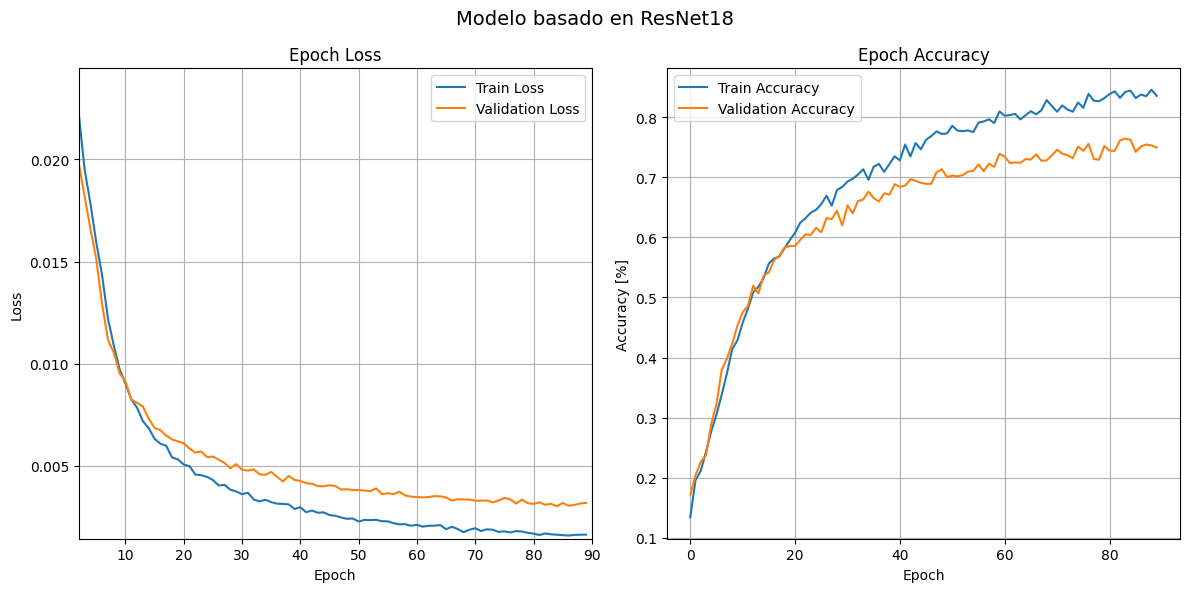

In [26]:
plot_metrics(model_resnet18,title="Modelo basado en ResNet18")

In [27]:
# Para probar que se haya guardado bien el mejor modelo entrenado
new_model = GazeEstimation_ResNet18()
new_model.load_state_dict(torch.load('./modelos/resnet18.pth'))
new_model.to(device)

inputs = torch.randn(8, 3, 224, 224).to(device) 
outputs = new_model(inputs) 

print(outputs)

tensor([[-0.1108, -0.0030],
        [-0.1430, -0.0145],
        [-0.1822, -0.0040],
        [-0.2658, -0.1156],
        [-0.1833, -0.0879],
        [-0.1825,  0.0470],
        [-0.1563, -0.0638],
        [-0.1483,  0.0911]], device='cuda:0', grad_fn=<AddmmBackward0>)


/tmp/ipykernel_2302380/3045565910.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_model.load_state_dict(torch.load('./modelos/resnet18.pth'))


## 3.3 Modelo basado en ResNet34

### 3.3.1 Instanciación

In [28]:
# Instanciación del modelo con resnet34
model_resnet34 = GazeEstimation_ResNet34(name="resnet34",pretrained=True,debug=False) #Debug en True para ver qué capas son entrenables y cuáles no
model_resnet34.dynamic_lr = False
model_resnet34.lr_epochs_adjustment = 30 # Cada 30 epochs se reduce el learning rate por un factor de 0.1

# Al ser un problema de regresión se usa MSELoss
criterion = nn.MSELoss()

# Optimizador: Adam
optimizer = torch.optim.Adam(model_resnet18.parameters(), lr=1e-5)

#Summary
summary(model_resnet34.to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

### 3.3.2 Entrenamiento

In [29]:
model_resnet34.fit(train_loader, val_loader, criterion, optimizer, epochs=90, device=device, save_model=True)

Epoch 1/90


Validation loss 0.04200: 100%|██████████| 25/25 [00:36<00:00,  1.44s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0446 / 8.86% | Validation Loss / Accuracy: 0.0420 / 10.79%
Epoch 2/90


Validation loss 0.04124: 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet34.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0448 / 9.35% | Validation Loss / Accuracy: 0.0412 / 10.52%
Epoch 3/90


Validation loss 0.04177: 100%|██████████| 25/25 [00:36<00:00,  1.46s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0441 / 9.63% | Validation Loss / Accuracy: 0.0418 / 10.59%
Epoch 4/90


Validation loss 0.04148: 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet34.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0442 / 9.67% | Validation Loss / Accuracy: 0.0415 / 10.77%
Epoch 5/90


Validation loss 0.04134: 100%|██████████| 25/25 [00:35<00:00,  1.43s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet34.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0444 / 9.28% | Validation Loss / Accuracy: 0.0413 / 10.19%
Epoch 6/90


Validation loss 0.04130: 100%|██████████| 25/25 [00:35<00:00,  1.44s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet34.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0438 / 9.32% | Validation Loss / Accuracy: 0.0413 / 10.76%
Epoch 7/90


Validation loss 0.04120: 100%|██████████| 25/25 [00:35<00:00,  1.42s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet34.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0438 / 10.52% | Validation Loss / Accuracy: 0.0412 / 10.27%
Epoch 8/90


Validation loss 0.04150: 100%|██████████| 25/25 [00:36<00:00,  1.44s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0444 / 9.77% | Validation Loss / Accuracy: 0.0415 / 10.56%
Epoch 9/90


Validation loss 0.04210: 100%|██████████| 25/25 [00:36<00:00,  1.46s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0445 / 9.36% | Validation Loss / Accuracy: 0.0421 / 10.73%
Epoch 10/90


Validation loss 0.04190: 100%|██████████| 25/25 [00:35<00:00,  1.43s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet34.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0445 / 9.50% | Validation Loss / Accuracy: 0.0419 / 9.93%
Epoch 11/90


Validation loss 0.04149: 100%|██████████| 25/25 [00:36<00:00,  1.44s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet34.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0441 / 9.82% | Validation Loss / Accuracy: 0.0415 / 10.38%
Epoch 12/90


Validation loss 0.04165: 100%|██████████| 25/25 [00:35<00:00,  1.43s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0442 / 10.29% | Validation Loss / Accuracy: 0.0417 / 10.95%
Epoch 13/90


Validation loss 0.04144: 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet34.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0443 / 9.79% | Validation Loss / Accuracy: 0.0414 / 10.05%
Epoch 14/90


Validation loss 0.04191: 100%|██████████| 25/25 [00:36<00:00,  1.44s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0444 / 9.45% | Validation Loss / Accuracy: 0.0419 / 11.41%
Epoch 15/90


Validation loss 0.04224: 100%|██████████| 25/25 [00:36<00:00,  1.44s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0446 / 9.55% | Validation Loss / Accuracy: 0.0422 / 10.99%
Epoch 16/90


Validation loss 0.04169: 100%|██████████| 25/25 [00:35<00:00,  1.42s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet34.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0443 / 9.28% | Validation Loss / Accuracy: 0.0417 / 10.64%
Epoch 17/90


Validation loss 0.04163: 100%|██████████| 25/25 [00:35<00:00,  1.43s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet34.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0444 / 9.72% | Validation Loss / Accuracy: 0.0416 / 10.27%
Epoch 18/90


Validation loss 0.04160: 100%|██████████| 25/25 [00:35<00:00,  1.43s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet34.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0447 / 9.95% | Validation Loss / Accuracy: 0.0416 / 10.44%
Epoch 19/90


Validation loss 0.04138: 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet34.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0447 / 8.91% | Validation Loss / Accuracy: 0.0414 / 11.23%
Epoch 20/90


Validation loss 0.04183: 100%|██████████| 25/25 [00:36<00:00,  1.44s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0445 / 9.79% | Validation Loss / Accuracy: 0.0418 / 10.66%
Epoch 21/90


Validation loss 0.04226: 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0446 / 9.86% | Validation Loss / Accuracy: 0.0423 / 9.65%
Epoch 22/90


Validation loss 0.04182: 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet34.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0441 / 8.89% | Validation Loss / Accuracy: 0.0418 / 10.61%
Epoch 23/90


Validation loss 0.04114: 100%|██████████| 25/25 [00:36<00:00,  1.46s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet34.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0444 / 9.29% | Validation Loss / Accuracy: 0.0411 / 11.55%
Epoch 24/90


Validation loss 0.04247: 100%|██████████| 25/25 [00:35<00:00,  1.43s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0441 / 10.43% | Validation Loss / Accuracy: 0.0425 / 9.56%
Epoch 25/90


Validation loss 0.04150: 100%|██████████| 25/25 [00:36<00:00,  1.46s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet34.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0441 / 9.10% | Validation Loss / Accuracy: 0.0415 / 11.32%
Epoch 26/90


Validation loss 0.04213: 100%|██████████| 25/25 [00:36<00:00,  1.47s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0448 / 9.51% | Validation Loss / Accuracy: 0.0421 / 10.00%
Epoch 27/90


Validation loss 0.04220: 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0444 / 10.09% | Validation Loss / Accuracy: 0.0422 / 9.46%
Epoch 28/90


Validation loss 0.04040: 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet34.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0446 / 9.22% | Validation Loss / Accuracy: 0.0404 / 12.15%
Epoch 29/90


Validation loss 0.04108: 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0444 / 8.54% | Validation Loss / Accuracy: 0.0411 / 11.11%
Epoch 30/90


Validation loss 0.04160: 100%|██████████| 25/25 [00:36<00:00,  1.44s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0447 / 9.66% | Validation Loss / Accuracy: 0.0416 / 10.76%
Epoch 31/90


Validation loss 0.04173: 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0447 / 9.05% | Validation Loss / Accuracy: 0.0417 / 10.23%
Epoch 32/90


Validation loss 0.04114: 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet34.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0444 / 9.78% | Validation Loss / Accuracy: 0.0411 / 11.15%
Epoch 33/90


Validation loss 0.04192: 100%|██████████| 25/25 [00:36<00:00,  1.48s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0443 / 9.64% | Validation Loss / Accuracy: 0.0419 / 10.75%
Epoch 34/90


Validation loss 0.04170: 100%|██████████| 25/25 [00:36<00:00,  1.44s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet34.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0439 / 9.80% | Validation Loss / Accuracy: 0.0417 / 10.82%
Epoch 35/90


Validation loss 0.04228: 100%|██████████| 25/25 [00:35<00:00,  1.44s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0445 / 9.39% | Validation Loss / Accuracy: 0.0423 / 9.26%
Epoch 36/90


Validation loss 0.04145: 100%|██████████| 25/25 [00:35<00:00,  1.44s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet34.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0441 / 9.74% | Validation Loss / Accuracy: 0.0415 / 9.51%
Epoch 37/90


Validation loss 0.04152: 100%|██████████| 25/25 [00:36<00:00,  1.48s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0442 / 9.12% | Validation Loss / Accuracy: 0.0415 / 11.45%
Epoch 38/90


Validation loss 0.04200: 100%|██████████| 25/25 [00:36<00:00,  1.46s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0438 / 10.02% | Validation Loss / Accuracy: 0.0420 / 9.80%
Epoch 39/90


Validation loss 0.04201: 100%|██████████| 25/25 [00:36<00:00,  1.48s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0441 / 9.55% | Validation Loss / Accuracy: 0.0420 / 9.61%
Epoch 40/90


Validation loss 0.04155: 100%|██████████| 25/25 [00:36<00:00,  1.46s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet34.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0445 / 9.01% | Validation Loss / Accuracy: 0.0415 / 11.39%
Epoch 41/90


Validation loss 0.04186: 100%|██████████| 25/25 [00:35<00:00,  1.44s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0441 / 9.65% | Validation Loss / Accuracy: 0.0419 / 9.49%
Epoch 42/90


Validation loss 0.04120: 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet34.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0444 / 9.68% | Validation Loss / Accuracy: 0.0412 / 9.70%
Epoch 43/90


Validation loss 0.04132: 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0439 / 9.24% | Validation Loss / Accuracy: 0.0413 / 10.34%
Epoch 44/90


Validation loss 0.04138: 100%|██████████| 25/25 [00:36<00:00,  1.47s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0444 / 8.89% | Validation Loss / Accuracy: 0.0414 / 11.15%
Epoch 45/90


Validation loss 0.04215: 100%|██████████| 25/25 [00:36<00:00,  1.47s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0440 / 9.00% | Validation Loss / Accuracy: 0.0421 / 10.32%
Epoch 46/90


Validation loss 0.04186: 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet34.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0444 / 10.18% | Validation Loss / Accuracy: 0.0419 / 10.16%
Epoch 47/90


Validation loss 0.04186: 100%|██████████| 25/25 [00:36<00:00,  1.46s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0441 / 9.55% | Validation Loss / Accuracy: 0.0419 / 11.18%
Epoch 48/90


Validation loss 0.04216: 100%|██████████| 25/25 [00:36<00:00,  1.47s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0444 / 8.97% | Validation Loss / Accuracy: 0.0422 / 10.14%
Epoch 49/90


Validation loss 0.04220: 100%|██████████| 25/25 [00:36<00:00,  1.47s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0440 / 9.30% | Validation Loss / Accuracy: 0.0422 / 9.38%
Epoch 50/90


Validation loss 0.04071: 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet34.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0441 / 9.98% | Validation Loss / Accuracy: 0.0407 / 10.07%
Epoch 51/90


Validation loss 0.04154: 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0441 / 10.05% | Validation Loss / Accuracy: 0.0415 / 10.84%
Epoch 52/90


Validation loss 0.04200: 100%|██████████| 25/25 [00:36<00:00,  1.46s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0434 / 10.20% | Validation Loss / Accuracy: 0.0420 / 12.04%
Epoch 53/90


Validation loss 0.04150: 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet34.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0440 / 9.97% | Validation Loss / Accuracy: 0.0415 / 9.94%
Epoch 54/90


Validation loss 0.04186: 100%|██████████| 25/25 [00:36<00:00,  1.47s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0444 / 8.81% | Validation Loss / Accuracy: 0.0419 / 9.79%
Epoch 55/90


Validation loss 0.04179: 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet34.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0437 / 10.49% | Validation Loss / Accuracy: 0.0418 / 9.82%
Epoch 56/90


Validation loss 0.04190: 100%|██████████| 25/25 [00:36<00:00,  1.46s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0446 / 9.20% | Validation Loss / Accuracy: 0.0419 / 10.76%
Epoch 57/90


Validation loss 0.04185: 100%|██████████| 25/25 [00:36<00:00,  1.48s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet34.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0446 / 8.98% | Validation Loss / Accuracy: 0.0419 / 10.61%
Epoch 58/90


Validation loss 0.04107: 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet34.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0442 / 9.40% | Validation Loss / Accuracy: 0.0411 / 11.85%
Epoch 59/90


Validation loss 0.04155: 100%|██████████| 25/25 [00:37<00:00,  1.49s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0447 / 8.77% | Validation Loss / Accuracy: 0.0416 / 10.09%
Epoch 60/90


Validation loss 0.04128: 100%|██████████| 25/25 [00:36<00:00,  1.46s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet34.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0439 / 9.37% | Validation Loss / Accuracy: 0.0413 / 11.30%
Epoch 61/90


Validation loss 0.04156: 100%|██████████| 25/25 [00:36<00:00,  1.47s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0442 / 9.33% | Validation Loss / Accuracy: 0.0416 / 9.69%
Epoch 62/90


Validation loss 0.04178: 100%|██████████| 25/25 [00:36<00:00,  1.46s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0444 / 8.87% | Validation Loss / Accuracy: 0.0418 / 9.40%
Epoch 63/90


Validation loss 0.04147: 100%|██████████| 25/25 [00:37<00:00,  1.48s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet34.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0448 / 9.49% | Validation Loss / Accuracy: 0.0415 / 9.77%
Epoch 64/90


Validation loss 0.04242: 100%|██████████| 25/25 [00:36<00:00,  1.47s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0442 / 9.24% | Validation Loss / Accuracy: 0.0424 / 12.19%
Epoch 65/90


Validation loss 0.04168: 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet34.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0434 / 9.65% | Validation Loss / Accuracy: 0.0417 / 10.59%
Epoch 66/90


Validation loss 0.04178: 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0446 / 8.84% | Validation Loss / Accuracy: 0.0418 / 11.41%
Epoch 67/90


Validation loss 0.04186: 100%|██████████| 25/25 [00:36<00:00,  1.46s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0445 / 9.44% | Validation Loss / Accuracy: 0.0419 / 10.18%
Epoch 68/90


Validation loss 0.04205: 100%|██████████| 25/25 [00:35<00:00,  1.44s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0451 / 9.41% | Validation Loss / Accuracy: 0.0420 / 9.80%
Epoch 69/90


Validation loss 0.04249: 100%|██████████| 25/25 [00:37<00:00,  1.48s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0442 / 9.17% | Validation Loss / Accuracy: 0.0425 / 10.59%
Epoch 70/90


Validation loss 0.04115: 100%|██████████| 25/25 [00:37<00:00,  1.49s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet34.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0441 / 8.95% | Validation Loss / Accuracy: 0.0412 / 9.98%
Epoch 71/90


Validation loss 0.04166: 100%|██████████| 25/25 [00:36<00:00,  1.46s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0448 / 9.32% | Validation Loss / Accuracy: 0.0417 / 9.24%
Epoch 72/90


Validation loss 0.04221: 100%|██████████| 25/25 [00:36<00:00,  1.46s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0442 / 9.71% | Validation Loss / Accuracy: 0.0422 / 10.56%
Epoch 73/90


Validation loss 0.04191: 100%|██████████| 25/25 [00:36<00:00,  1.48s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet34.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0443 / 9.95% | Validation Loss / Accuracy: 0.0419 / 10.51%
Epoch 74/90


Validation loss 0.04131: 100%|██████████| 25/25 [00:36<00:00,  1.46s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet34.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0440 / 9.92% | Validation Loss / Accuracy: 0.0413 / 10.54%
Epoch 75/90


Validation loss 0.04145: 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0445 / 9.32% | Validation Loss / Accuracy: 0.0415 / 10.96%
Epoch 76/90


Validation loss 0.04221: 100%|██████████| 25/25 [00:37<00:00,  1.48s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0438 / 10.18% | Validation Loss / Accuracy: 0.0422 / 10.48%
Epoch 77/90


Validation loss 0.04130: 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet34.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0445 / 9.76% | Validation Loss / Accuracy: 0.0413 / 9.04%
Epoch 78/90


Validation loss 0.04154: 100%|██████████| 25/25 [00:36<00:00,  1.47s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0436 / 10.45% | Validation Loss / Accuracy: 0.0415 / 10.50%
Epoch 79/90


Validation loss 0.04182: 100%|██████████| 25/25 [00:36<00:00,  1.48s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0443 / 10.22% | Validation Loss / Accuracy: 0.0418 / 10.75%
Epoch 80/90


Validation loss 0.04248: 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0448 / 9.43% | Validation Loss / Accuracy: 0.0425 / 9.75%
Epoch 81/90


Validation loss 0.04141: 100%|██████████| 25/25 [00:36<00:00,  1.46s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet34.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0441 / 8.78% | Validation Loss / Accuracy: 0.0414 / 10.95%
Epoch 82/90


Validation loss 0.04189: 100%|██████████| 25/25 [00:37<00:00,  1.48s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0443 / 9.37% | Validation Loss / Accuracy: 0.0419 / 9.85%
Epoch 83/90


Validation loss 0.04179: 100%|██████████| 25/25 [00:49<00:00,  1.97s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet34.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0440 / 9.59% | Validation Loss / Accuracy: 0.0418 / 9.82%
Epoch 84/90


Validation loss 0.04132: 100%|██████████| 25/25 [01:01<00:00,  2.47s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet34.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0441 / 10.02% | Validation Loss / Accuracy: 0.0413 / 10.39%
Epoch 85/90


Validation loss 0.04204: 100%|██████████| 25/25 [00:42<00:00,  1.69s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0444 / 9.85% | Validation Loss / Accuracy: 0.0420 / 11.40%
Epoch 86/90


Validation loss 0.04122: 100%|██████████| 25/25 [00:45<00:00,  1.82s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet34.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0447 / 8.91% | Validation Loss / Accuracy: 0.0412 / 11.25%
Epoch 87/90


Validation loss 0.04199: 100%|██████████| 25/25 [00:37<00:00,  1.52s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0447 / 9.51% | Validation Loss / Accuracy: 0.0420 / 8.95%
Epoch 88/90


Validation loss 0.04156: 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet34.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0444 / 9.24% | Validation Loss / Accuracy: 0.0416 / 10.04%
Epoch 89/90


Validation loss 0.04158: 100%|██████████| 25/25 [00:38<00:00,  1.53s/it]


[Lr:1e-05] Training Loss / Accuracy: 0.0440 / 9.64% | Validation Loss / Accuracy: 0.0416 / 10.38%
Epoch 90/90


Validation loss 0.04251: 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

[Lr:1e-05] Training Loss / Accuracy: 0.0439 / 9.25% | Validation Loss / Accuracy: 0.0425 / 9.57%


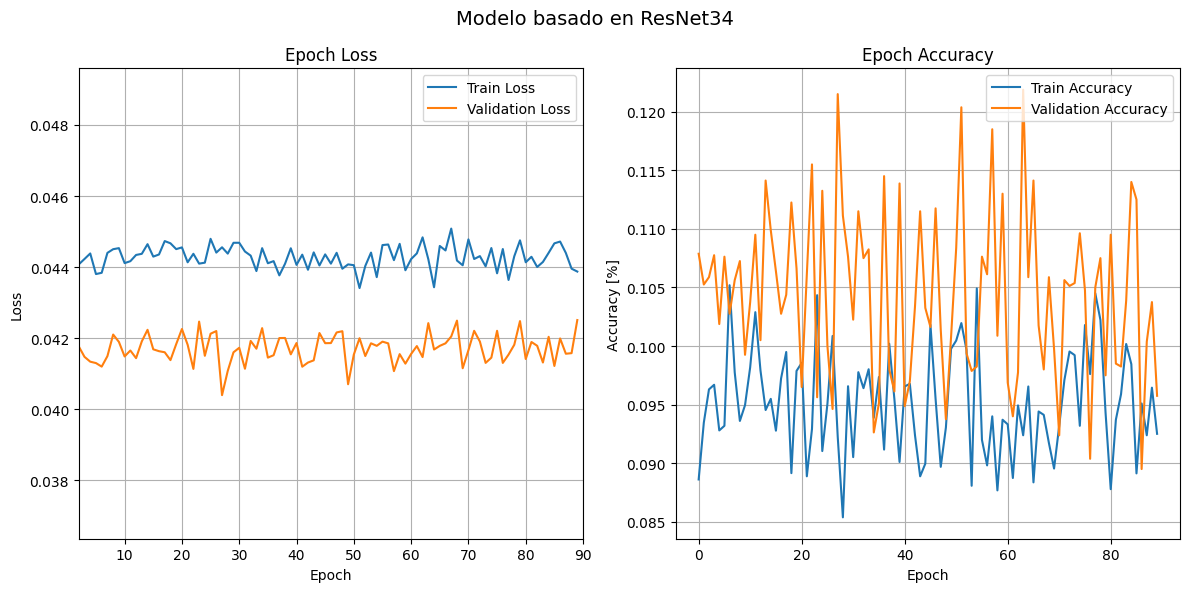

In [30]:
plot_metrics(model_resnet34,title="Modelo basado en ResNet34")

In [31]:
# Para probar que se haya guardado bien el mejor modelo entrenado
loaded_model = GazeEstimation_ResNet34()
loaded_model.load_state_dict(torch.load('./modelos/resnet18.pth'))
loaded_model.to(device)

inputs = torch.randn(8, 3, 224, 224).to(device) 
outputs = loaded_model(inputs) 

print(outputs)

/tmp/ipykernel_2302380/1033572697.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_model.load_state_dict(torch.load('./modelos/resnet34.pth'))


tensor([[-0.0349,  0.0415],
        [-0.0670,  0.0069],
        [ 0.0429, -0.0264],
        [-0.1208, -0.0031],
        [-0.0376, -0.0054],
        [-0.1497,  0.0003],
        [ 0.0909, -0.0796],
        [ 0.0927, -0.1453]], device='cuda:0', grad_fn=<AddmmBackward0>)


## 3.4 Validación

Se toma una imagen al azar y se visualiza la dirección de la mirada actual VS la predicha
- Flecha azul: indica la posición de la mirada verdadera.
- Flecha verde: indica la posición de la mirada predicha por el modelo.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Actual: 
	 pitch=-0.189 rad | yaw=-0.238 rad
	 proyección 2D del ángulo: 322.21° deg
Predicted: 
	 pitch=-0.197 rad | yaw=-0.188 rad
	 proyección 2D del ángulo: 314.14° deg
**Preciso (tolerancia = 15°): 1


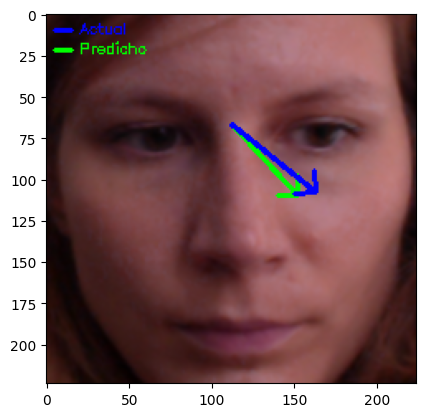

In [32]:
# Se elige el modelo a probar
model = loaded_model

# Se elige imagen al azar y se obtienen sus labesl (pitch,yaw)
img, gaze = test_dataset[randint(0,len(test_dataset)-1)]
pitch = gaze[0]
yaw = gaze[1]
angle = angle_to_2d(np.array([gaze]))

# Ahora se pasa la imagen por el modelo y se obtiene la predicción
predicted_gaze = model(img.unsqueeze(0).to(device))
pitch_predicted = predicted_gaze[0][0].item()
yaw_predicted = predicted_gaze[0][1].item()
img = img.squeeze(0).detach().cpu().numpy().transpose(1,2,0)
predicted_gaze = predicted_gaze.squeeze(0).detach().cpu().numpy()
angle_predicted = angle_to_2d(np.array([predicted_gaze]))

# Se define la tolerancia para considerar una predicción como precisa o no 
tolerancia = 15 # 15° de tolerancia para considerar una predicción como error
accurate = int(is_accurate(angle,angle_predicted,tolerance=tolerancia)[0])

# Impresión de parámetros
print("Actual: ")
print(f"\t pitch={pitch:.3f} rad | yaw={yaw:.3f} rad")
print(f"\t proyección 2D del ángulo: {angle[0]:.2f}° deg")
print("Predicted: ")
print(f"\t pitch={pitch_predicted:.3f} rad | yaw={yaw_predicted:.3f} rad")
print(f"\t proyección 2D del ángulo: {angle_predicted[0]:.2f}° deg")
print(f"**Preciso (tolerancia = {tolerancia}°): {accurate}")

# Se agregan anotaciones a la imagen
img = put_gaze_annotation(img,predicted_gaze,method=1,color=(0,255,0), label="Predicho",label_y=22) #Prediced: flecha verde
img = put_gaze_annotation(img,gaze,method=1,color=(255,0,0),label="Actual",label_y=10) #Actual: flecha azul

# Mostrar imagen (se convierte a RGB porque openCV trabaja en BGR)
plt.imshow(rgb(img))

## 3.5 Visualización de métricas en Tensorboard

In [33]:
%load_ext tensorboard
%tensorboard --logdir tensorboard

Reusing TensorBoard on port 6006 (pid 1793849), started 15:52:46 ago. (Use '!kill 1793849' to kill it.)

## 4. Ajuste de hiperparámetros

Se busca responder la siguiente consigna del TP: 

> Entrenamientos realizados (al menos 4). Hiperparametros utilizados en cada uno.

- Instanciar el modelo con diferentes nombres asi se guardan distintos modelos en TensorBoard y es más fácil comparar
